In [2]:
import open3d as o3d
from collections import defaultdict
import numpy as np
from scipy.optimize import minimize
import cv2

In [46]:
pcd = o3d.geometry.PointCloud()

box1 = o3d.geometry.TriangleMesh.create_box(width=1.0, height=1.0, depth=1.0)
box1.paint_uniform_color([0,1, 0])
box2 = o3d.geometry.TriangleMesh.create_box(width=0.5, height=0.5, depth=0.5)
box2.paint_uniform_color([0, 0, 1])
box2.translate((1.5, 1.5, 0))

pcd = box1.sample_points_uniformly(number_of_points=10000) + box2.sample_points_uniformly(number_of_points=10000)

o3d.io.write_point_cloud("simple_cloud.ply", pcd)

[Open3D WARNING] Write Ply clamped color value to valid range


True

In [51]:
# load the point cloud and compute the normals
#/Users/owenburns/workareas/Voxel-Aligned-Concept-Clouds/bbox_test.ply
pcd = o3d.io.read_point_cloud("/Users/owenburns/workareas/Voxel-Aligned-Concept-Clouds/bbox_test.ply")
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

In [52]:
view_renders = []
world_up = np.array([0, 1, 0])
zoom = 0.3
# followed this tutorial to get the camera matrix: https://learnopengl.com/Getting-started/Camera

FOV = 60
img_dim = 512
fx = fy = img_dim/np.tan(np.deg2rad(FOV/2))

intrinsics = np.array([
    [fx, 0, -img_dim/2],
    [0, fy, -img_dim/2],
    [0, 0, -1],
])

# iteratively take the pictures
while np.array(pcd.points).shape[0] > 1000:

    # get the center of the point cloud
    average_point = np.mean(np.asarray(pcd.points), axis=0) + np.random.normal(0, 0.2, 3)

    # get the average normal of the point cloud, weighted by distance from the center
    normals = np.asarray(pcd.normals)
    distances = np.linalg.norm(np.asarray(pcd.points) - average_point, axis=1)
    weights = 1 / (distances + 1e-8)  # Add a small value to avoid division by zero
    weighted_normals = np.average(normals, axis=0, weights=weights)
    weighted_normals /= np.linalg.norm(weighted_normals)

    lookat = -weighted_normals
    position = average_point - zoom*lookat

    z_axis = lookat # direction
    z_axis /= np.linalg.norm(z_axis)
    x_axis = np.cross(world_up, z_axis) # right
    x_axis /= np.linalg.norm(x_axis)
    y_axis = np.cross(z_axis, x_axis) # up
    y_axis /= np.linalg.norm(y_axis)

    # Assemble rotation matrix R and translation vector t
    R = np.eye(4)
    R[:3, :3] = np.row_stack((x_axis, y_axis, z_axis))
    T = np.eye(4)
    T[:3, 3] = -position
    extrinsics = R @ T
    extrinsics = extrinsics[:3, :]

    camera_matrix = np.dot(intrinsics, extrinsics)

    projected_points = np.dot(camera_matrix, np.vstack([np.asarray(pcd.points).T, np.ones(len(pcd.points))]))
    depth = projected_points[2]
    x_coords = projected_points[0] / depth
    y_coords = projected_points[1] / depth

    frustrum_indices = np.where((x_coords >= 0) & (x_coords < 512) & (y_coords >= 0) & (y_coords < 512))[0]

    print(f"removing {len(frustrum_indices)} points")

    if len(frustrum_indices) < 100:
        zoom += 0.1

    image = np.zeros((512, 512, 3), dtype=np.uint8)
    colors = np.array(pcd.colors)
    image[y_coords[frustrum_indices].astype(int), x_coords[frustrum_indices].astype(int)] = colors[frustrum_indices] * 255
    image[240:260, 240:260] = [255, 0, 0]  # Draw a red square at the camera location
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"vafs_segmentation_images/render_{len(view_renders)}.png", image)

    view_renders.append((camera_matrix, image))

    # Remove the points in the camera view, but first save a copy of the point cloud that highlights in red the points that were removed.
    pcd_render = o3d.geometry.PointCloud(pcd)
    colors = np.asarray(pcd.colors)
    colors[frustrum_indices] = [255, 0, 0]
    pcd_render.colors = o3d.utility.Vector3dVector(colors)

    pcd = pcd.select_by_index(frustrum_indices, invert=True)
    # pcd.estimate_normals()
    # pcd.orient_normals_consistent_tangent_plane(100)

    sphere_camera = o3d.geometry.TriangleMesh.create_sphere(radius=0.02)
    sphere_camera.translate(position)
    sphere_camera.paint_uniform_color([1, 0, 0])  # Red sphere at camera position

    sphere_average = o3d.geometry.TriangleMesh.create_sphere(radius=0.02)
    sphere_average.translate(average_point)
    sphere_average.paint_uniform_color([0, 1, 0])  # Green sphere at average point

    camera_view = o3d.geometry.TriangleMesh.create_cone(radius=0.1, height=0.5)  # Adjust radius and height as needed
    camera_view.translate(position)  # Position the cone at the camera location
    camera_view.rotate(R[:3,:3].T)  # Align the cone with the camera's rotation matrix (look direction)
    camera_view.paint_uniform_color([0, 0, 1])  # Blue cone for the camera view direction

    # Combine the point cloud and spheres
    pcd_with_spheres = pcd_render + sphere_camera.sample_points_uniformly(number_of_points=1000)
    pcd_with_spheres += sphere_average.sample_points_uniformly(number_of_points=1000)
    pcd_with_spheres += camera_view.sample_points_uniformly(number_of_points=1000)

    # Save the point cloud with spheres for visualization
    o3d.io.write_point_cloud(f"vafs_segmentation_images/pcd_{len(view_renders)}.ply", pcd_with_spheres)

removing 0 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 319 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 822 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 8744 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 16339 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 6999 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 8274 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 98 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 6452 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 2339 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 0 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 7790 points
[Open3D WARNING] Write Ply clamped color value to valid range
removing 1087

In [10]:
# Create image with camera matrix

projected_points = np.dot(camera_matrix, np.vstack([np.asarray(pcd.points).T, np.ones(len(pcd.points))]))

# Calculate the depth of each point
depth = projected_points[2]

# Calculate the x and y coordinates of each point
x_coords = projected_points[0] / depth
y_coords = projected_points[1] / depth

# Calculate the indices of the points that are within the image bounds
frustrum_indices = np.where((x_coords >= 0) & (x_coords < 512) & (y_coords >= 0) & (y_coords < 512))[0]

print(frustrum_indices.shape)

(13535,)


x_max: 1.598752498626709
x_min: -0.7994198799133301
y_max: 1.1383886337280273
y_min: -0.13229729235172272
z_max: 0.582999050617218
z_min: 0.05058826878666878


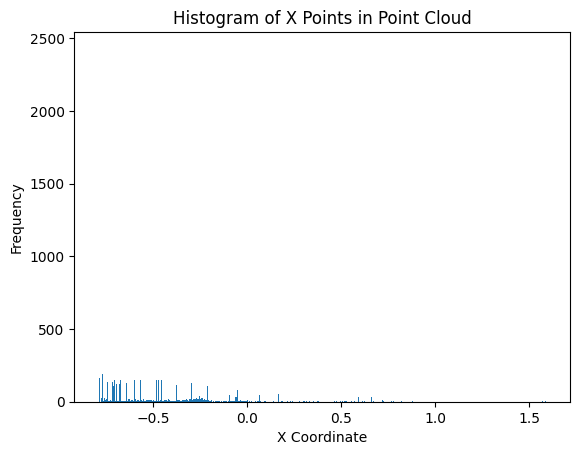

In [10]:
import numpy as np

import matplotlib.pyplot as plt

# Extract x coordinates from the point cloud
x_points = np.asarray(pcd.points)[:, 0]
y_points = np.asarray(pcd.points)[:, 1]
z_points = np.asarray(pcd.points)[:, 2]

print(f"x_max: {np.max(x_points)}")
print(f"x_min: {np.min(x_points)}")
print(f"y_max: {np.max(y_points)}")
print(f"y_min: {np.min(y_points)}")
print(f"z_max: {np.max(z_points)}")
print(f"z_min: {np.min(z_points)}")

# Calculate the number of bins required for the average box to have 10 points
num_bins = len(x_points) // 10

# Plot the histogram
plt.hist(x_points, bins=num_bins)
plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of X Points in Point Cloud')
plt.show()

In [ ]:
# first we need to constraint the number of possible positions
# we do this by finding the point where the most normals intersect iteratively until all normals are accounted for
# we can constraint the focal length and stuff to simply the image dimension that will later be anticipated by the segmentation model
# then we calculate the set of points in each range
# then we construct our dual range space using our (x,y,z,x_angle,y_angle,z_angle,fx,fy,cx,cy) tuples
# then we can solve using the https://link.springer.com/article/10.1007/s00454-019-00099-6 approach

In [ ]:
import numpy as np
from sympy import *
from IPython.display import display
from scipy.optimize import minimize

# # Define camera intrinsic parameters
# fx = fy = 512.0  # Focal length in pixels
# cx = 512 / 2.0  # Principal point x-coordinate
# cy = 512 / 2.0  # Principal point y-coordinate

# # Create the intrinsic matrix
# intrinsics = np.array([
#     [fx, 0, cx],
#     [0, fy, cy],
#     [0, 0, 1],
# ])

# x, y, z, yaw, pitch, roll = symbols('x y z alpha beta gamma')

# extrinsic = Matrix([
#     [cos(yaw) * cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll), x],
#     [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll), y],
#     [-sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll), z],
# ])

# symbolic_cam_matrix = intrinsics * extrinsic
# display(symbolic_cam_matrix)

def points_in_frustrum(x, y, z, yaw, pitch, roll):
    # Define the camera intrinsic parameters
    fx = fy = 512.0  # Focal length in pixels
    cx = 512 / 2.0  # Principal point x-coordinate
    cy = 512 / 2.0  # Principal point y-coordinate

    # Create the intrinsic matrix
    intrinsics = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1],
    ])

    # Create the extrinsic matrix
    extrinsic = Matrix([
        [cos(yaw) * cos(pitch), cos(yaw)*sin(pitch)*sin(roll) - sin(yaw)*cos(roll), cos(yaw)*sin(pitch)*cos(roll) + sin(yaw)*sin(roll), x],
        [sin(yaw)*cos(pitch), sin(yaw)*sin(pitch)*sin(roll) + cos(yaw)*cos(roll), sin(yaw)*sin(pitch)*cos(roll) - cos(yaw)*sin(roll), y],
        [-sin(pitch), cos(pitch)*sin(roll), cos(pitch)*cos(roll), z],
    ])

    # Calculate the camera matrix
    cam_matrix = intrinsics * extrinsic

    # Project the point cloud into the camera frame
    projected_points = np.dot(cam_matrix, np.vstack([np.asarray(pcd.points).T, np.ones(len(pcd.points))]))

    # Calculate the depth of each point
    depth = projected_points[2]

    # Calculate the x and y coordinates of each point
    x_coords = projected_points[0] / depth
    y_coords = projected_points[1] / depth

    # Calculate the indices of the points that are within the image bounds
    frustrum_indices = np.where((x_coords >= 0) & (x_coords < 512) & (y_coords >= 0) & (y_coords < 512))[0]

    # compute the lookat vector of the camera in the world frame
    lookat = np.array([cos(yaw)*cos(pitch), sin(yaw)*cos(pitch), -sin(pitch)])

    # find the points with normals within 90 degrees of the lookat vector
    lookat_indices = np.where(np.dot(np.asarray(pcd.normals), lookat) > cos(np.pi / 2))[0]

    # find the intersection of the two sets of indices
    indices = np.intersect1d(frustrum_indices, lookat_indices)

    print(indices.shape[0])

    # return indices.shape[0]

for x in np.linspace(-1,2,30):
    for y in np.linspace(-0.5,1.5,20):
        for z in np.linspace(0,1,10):
            for yaw in np.linspace(0, 2*np.pi, 8):
                for pitch in np.linspace(0, 2*np.pi, 8):
                    for roll in np.linspace(0, 2*np.pi, 8):
                        points_in_frustrum(x, y, z, yaw, pitch, roll)

0
97
0
0
0
0
27
0
0
0
0
0
0
0
0
0
0
176
0


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107245890>>
Traceback (most recent call last):
  File "/Users/owenburns/anaconda3/envs/DiffusionEarth/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
